In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# scores
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [236]:
#define category columns
cat_cols = {
    'grade': 'category',
    'sub_grade': 'category',
    'home_ownership': 'category',
    'verification_status': 'category',
    'loan_status': 'category',
    'purpose':'category',
    'addr_state':'category',
    'initial_list_status':'category',
    'inq_last_6mths_cat': 'category',
    'pub_rec_cat':'category',
    'fully_funded':'category'
}

# import data
df_raw = pd.read_csv('../data/processed/LCData_processed.csv', dtype=cat_cols, index_col=0)


## Question 1 (Classification)

If you perform a simple multivariate logistic regression of “loan defaults” on all your engineered features how well does your model explain the data? 

* What is your R2, RSE, or other measure of model fit? 
* What about your validation or cross validation accuracy? 
* How does this accuracy compare to the benchmark of just predicting the majority class in the training set? 
* How does this accuracy compare to the benchmark of using lending club’s loan grade to predict defaults?

I still have null data contained in the dataframe.  I've left null data in order to view results of removing rows vs imputing missing data. 

As a first test - let's simply remove the null data to get a model up and running. 

In [237]:
# have a look at columns with missing data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887379 entries, 0 to 887378
Data columns (total 44 columns):
loan_amnt                     887379 non-null float64
funded_amnt                   887379 non-null float64
funded_amnt_inv               887379 non-null float64
term                          887379 non-null int64
int_rate                      887379 non-null float64
installment                   887379 non-null float64
grade                         887379 non-null category
sub_grade                     887379 non-null category
emp_length                    887379 non-null int64
home_ownership                887379 non-null category
annual_inc                    887375 non-null float64
verification_status           887379 non-null category
loan_status                   887379 non-null category
purpose                       887379 non-null category
addr_state                    887379 non-null category
dti                           887379 non-null float64
delinq_2yrs           

The column **revol_util** relates to the amount of credit the borrower is using relative to all available revolving credit.  Imputing data for this column could negatively represent the amount of credit used by a borrower.  Let's drop the data.

In [238]:
# drop null data
df_processed = df_raw[pd.notnull(df_raw.revol_util)]

The column **collections_12_mths_ex_med** relates to the number of collections in 12 months excluding medical collections.  Imputing this data could negatively impact a borrower's attributes (since we may state they have more collections than they actualy do).  Let's simply remove the rows with this data missing.  

In [239]:
# drop null data
df_processed = df_processed[pd.notnull(df_processed.collections_12_mths_ex_med)]

Finally, we have 3 columns that are missing ~70,000 records:

* tot_coll_amt                  
* tot_cur_bal  
* total_rev_hi_lim

I do not want to lose 70,000 records, so I am going to remove the columns for this classification process

In [240]:
# remove 3 columns
df_processed = df_processed.drop(['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'], axis=1)

In [241]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886764 entries, 0 to 887378
Data columns (total 41 columns):
loan_amnt                     886764 non-null float64
funded_amnt                   886764 non-null float64
funded_amnt_inv               886764 non-null float64
term                          886764 non-null int64
int_rate                      886764 non-null float64
installment                   886764 non-null float64
grade                         886764 non-null category
sub_grade                     886764 non-null category
emp_length                    886764 non-null int64
home_ownership                886764 non-null category
annual_inc                    886764 non-null float64
verification_status           886764 non-null category
loan_status                   886764 non-null category
purpose                       886764 non-null category
addr_state                    886764 non-null category
dti                           886764 non-null float64
delinq_2yrs           

We are now good to go on building a model.  Let's begin by performing a simple multivariate logistic regression of “loan defaults” on all engineered features.

In [242]:
# create a list of my engineered feature names
feat_eng_cols = ['low_deliquences_jobs',
                 'issue_month', 
                 'issue_year', 
                 'inq_last_6mths_cat',
                 'pub_rec_cat',
                 'fully_funded'
                 ]

In [243]:
# We are trying to determine whether or not a loan has 'defaulted'.  
# As a result, we only want to look at loans that are complete, meaning 
# we drop loans that are current, or haven't defaulted fully.  We only look at loans within the below status'
status = ['Fully Paid', 
          'Charged Off', 
          'Default', 
          'Does not meet the credit policy. Status:Fully Paid',
          'Does not meet the credit policy. Status:Charged Off']

# filter out loans
df = df_processed[df_processed.loan_status.str.contains('|'.join(status))]

In [244]:
sc = StandardScaler()

# create our X and y datasets
X = df[feat_eng_cols]
y = df.default_status

# create the dummies for our category columns
X = pd.get_dummies(X)
X = sc.fit_transform(X)

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# fit the classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# how is our class order defined? 
clf.classes_

array([0, 1])

In [245]:
# predict X
y_pred = clf.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score = clf.predict_proba(X_test)[:,1]

# find the scores
r2_score_test = clf.score(X_test, y_test)
mse_test = mean_squared_error(y_test,y_pred)
roc_test = roc_auc_score(y_test, y_score)

# print scores
print('r2 test: {}'.format(r2_score_test))
print('mse: {}'.format(mse_test))
print('roc: {}'.format(roc_test))

r2 test: 0.8153460021513087
mse: 0.1846539978486913
roc: 0.5430065556373019


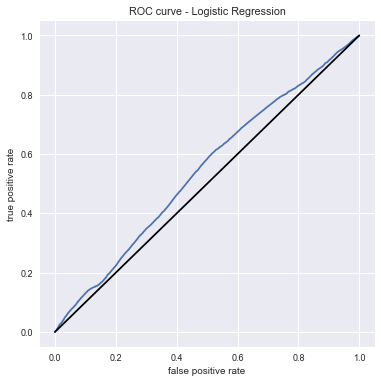

In [246]:
# plot the ROC curve
plt.figure(figsize=(6,6))

# calculate false positives & true positives
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# plot ROC curve & 50% line
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], color='black')

# set labels
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve - Logistic Regression')

plt.show()

In [247]:
# create target_names
t_names = ['0', '1']

print(classification_report(y_test, y_pred, target_names=t_names))

             precision    recall  f1-score   support

          0       0.82      1.00      0.90     52302
          1       0.00      0.00      0.00     11845

avg / total       0.66      0.82      0.73     64147



//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [249]:
# create confusion matrix
confusion_matrix(y_test, y_pred)

array([[52302,     0],
       [11845,     0]])

In [250]:
# let's find the cross validation score
scores = cross_val_score(clf, X, y, cv=5)
scores

array([ 0.81622433,  0.81624023,  0.81624023,  0.81624023,  0.81624023])

In [251]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.00001)


It's not looking good.  With a ROC score of 54%, we have the accuracy equivalent to that of randomly guessing the class.  

As you can see by the classificaiton report, precision and recall for the positive class is 0, meaning we cannot accurate predict the outcomes. 

**How does this accuracy compare to the benchmark of just predicting the majority class in the training set?**

**How does this accuracy compare to the benchmark of using lending club’s loan grade to predict defaults?**


In [254]:
# Lets calculate the default rates for loans based on lending club's grades
for g in sorted(df.grade.unique()):
    
    #calculate default rate
    default_rate = df[(df.default_status ==1) & (df.grade==g)].loan_amnt.count() / df[df.grade==g].loan_amnt.count() 

    print('{0}: {1:.3f}'.format(g, default_rate))

A: 0.063
B: 0.128
C: 0.198
D: 0.265
E: 0.332
F: 0.389
G: 0.410


In [257]:
# Lets calculate the expected default rates for loans by grade using our classifier 

grade_scores = {}

# loop through each grade
for g in sorted(df.grade.unique()):
    df_grades = df[df.grade==g]

    # create our X and y datasets
    X = df_grades[feat_eng_cols]
    y = df_grades.default_status

    # create the dummies for our category columns & scale
    X = pd.get_dummies(X)
    X = sc.fit_transform(X)

    # split our data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # fit the classifier
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    # find the scores
    print('{0}: {1:.3f}'.format(g, np.mean(clf.predict_proba(X_train)[:, 1])))

A: 0.063
B: 0.127
C: 0.199
D: 0.267
E: 0.331
F: 0.389
G: 0.407


Our classifier returns expected default rates per grade very close to what we see calculated by Lending Clubs loan grades. 

## Question 2 (Classification)

In the last question you used all your engineered features in making your model.
* Was this a good idea? 
* Are some of your features correlated and did you discover this during preprocessing? 
* Is your model suffering from the curse of dimensionality with many features, some of which don’t provide additional value potentially due to correlation? 
* Do feature selection by hand, through stepwise regression, or do dimension reduction. What is your R2, RSE, or other measure of your new model fit with feature selection? 
* Now, Pick another model type entirely such as knn, decision trees, or random forest. Consider that certain algorithms such as decision trees do feature selection for you while knn does not. Can you improve upon the performance compared to your previous models using this new model type?
* Which algorithm performed best? How do you define best? 
* Why did this algorithm perform best? 
* Now compare all the different models you made on your test set. 

In [260]:
# Using only the engineered features did not go very well - our precision and recall scores 
# for the positive class were zero. We need additional features to help us improve our model 
# performance.  Let's consider using ALL features for a model this time around.

# I know that there are several columns which are heavily correlated with the default status - so I will 
# remove these columns to see how the model does without them.  In particular, we will drop:
    
drop_cols = ['grade',
            'sub_grade',
            'loan_status',
            'int_rate',
            'default_status']

In [261]:
# create our X and y datasets
X = df.drop(drop_cols, axis=1)
y = df.default_status

# create the dummies for our category columns & scale
X = pd.get_dummies(X)
X = sc.fit_transform(X)

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# fit the classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# how is our class order defined? 
clf.classes_

array([0, 1])

In [262]:
# predict X
y_pred = clf.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score = clf.predict_proba(X_test)[:,1]

# find the scores
r2_score_test = clf.score(X_test, y_test)
mse_test = mean_squared_error(y_test,y_pred)
roc_test = roc_auc_score(y_test, y_score)

# print scores
print('r2 test: {}'.format(r2_score_test))
print('mse: {}'.format(mse_test))
print('roc: {}'.format(roc_test))

r2 test: 0.9966639125758024
mse: 0.003336087424197546
roc: 0.9990867581898735


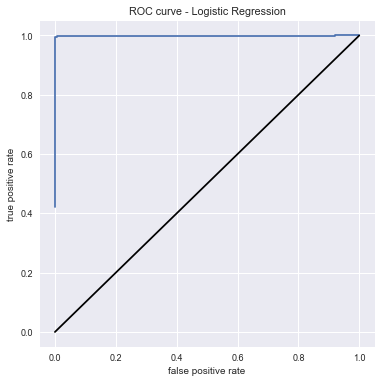

In [263]:
# plot the ROC curve
plt.figure(figsize=(6,6))

# calculate false positives & true positives
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# plot ROC curve & 50% line
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], color='black')

# set labels
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve - Logistic Regression')

plt.show()

In [264]:
# create target_names
t_names = ['0', '1']

print(classification_report(y_test, y_pred, target_names=t_names))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     52302
          1       1.00      0.98      0.99     11845

avg / total       1.00      1.00      1.00     64147



# ISSUES

* Within Question #1 - I'm not sure how to approach the following question: **How does this accuracy compare to the benchmark of just predicting the majority class in the training set?**
    * Is this suppose to be done using LogisticRegression?  If so, I don't understand how the parameters would be setup to create the model.
    
* Within Question #2 - I receive a fantastic score using logistic regression on the lending data classificaiton - however I believe this is incorrect and I don't know why.  I would expect to receive a score somewhere in the 80% range, which could be improved using feature selection and hyperparameter tuning.  But this is not the case.  

Am I approaching these questions incorrectly? 